This notebook calculates the change in indirect damage for specified hazard maps

In [1]:
# Imports
import configparser
from pathlib import Path
import pathlib
from direct_damages import damagescanner_rail_track as ds
import pandas as pd
import geopandas as gpd
# import datetime
from ci_adapt_utilities import *
import pickle
import networkx as nx

In [2]:
# Load configuration with ini file (created running config.py)
config_file=r'C:\repos\ci_adapt\config_ci_adapt.ini'
config = configparser.ConfigParser()
config.read(config_file)

p = Path('..')
hazard_type = config.get('DEFAULT', 'hazard_type')
infra_type = config.get('DEFAULT', 'infra_type')
country_code = config.get('DEFAULT', 'country_code')
country_name = config.get('DEFAULT', 'country_name')
hazard_data_subfolders = config.get('DEFAULT', 'hazard_data_subfolders')
asset_data = config.get('DEFAULT', 'asset_data')
vulnerability_data = config.get('DEFAULT', 'vulnerability_data')
data_path = Path(pathlib.Path.home().parts[0]) / 'Data'
interim_data_path = data_path / 'interim' / 'collected_flood_runs'

In [3]:
# Define costs for different transport modes
average_train_load_tons = (896+1344+2160+1344+896+896+1344+1512+896+390)/10 # in Tons per train. Source: Kennisinstituut voor Mobiliteitsbeleid. 2023. Cost Figures for Freight Transport – final report
average_train_cost_per_ton_km = (0.014+0.018+0.047+0.045)/4 # in Euros per ton per km. Source: Kennisinstituut voor Mobiliteitsbeleid. 2023. Cost Figures for Freight Transport – final report
average_road_cost_per_ton_km = (0.395+0.375+0.246+0.203+0.138+0.153+0.125+0.103+0.122+0.099)/10 # in Euros per ton per km. Source: Kennisinstituut voor Mobiliteitsbeleid. 2023. Cost Figures for Freight Transport – final report

In [4]:
# Define basic functions
def calculate_new_paths(graph0, shortest_paths, disrupted_edges):
    graph=graph0.copy()
    for u,v in set(disrupted_edges):
        graph.remove_edge(u,v,0)
        
    disrupted_shortest_paths={}
    for (origin,destination), (nodes_in_spath,demand) in shortest_paths.items():
        edges_in_spath=[(nodes_in_spath[i],nodes_in_spath[i+1]) for i in range(len(nodes_in_spath)-1)]
        if set(disrupted_edges).isdisjoint(edges_in_spath):
            continue
        else:
            try:
                disrupted_shortest_paths[(origin,destination)] = (nx.shortest_path(graph, origin, destination, weight='weight'), demand)
            except nx.NetworkXNoPath:
                print(f'No path between {origin} and {destination}. Cannot ship by train.')
                disrupted_shortest_paths[(origin,destination)] = (None, demand)
                continue
    
    return disrupted_shortest_paths

def calculate_economic_impact_shortest_paths(graph, shortest_paths, disrupted_shortest_paths, average_train_load_tons, average_train_cost_per_ton_km, average_road_cost_per_ton_km):
    # returns the economic impact for an infrastructure region given the infrastructure graph and shortest paths between ods, a set of disrupted shortest paths and the average train loads and costs

    # Initialize the economic impact variable
    economic_impact = 0
    # Loop through the edges where there is a change in flow
    for (origin, destination), (nodes_in_path, demand) in disrupted_shortest_paths.items():
        length_old_path=0
        for i in range(len(shortest_paths[(origin, destination)][0])-1):
            length_old_path += graph.edges[shortest_paths[(origin, destination)][0][i], shortest_paths[(origin, destination)][0][i+1], 0]['length']/1000
                     
        if (nodes_in_path is None) or ('_d' in str(nodes_in_path)):
            economic_impact += demand*average_train_load_tons*(average_road_cost_per_ton_km-average_train_cost_per_ton_km)*length_old_path
            continue


        else:
            length_new_path=0
            for i in range(len(nodes_in_path)-1):
                length_new_path += graph.edges[nodes_in_path[i], nodes_in_path[i+1], 0]['length']/1000
            economic_impact += demand*average_train_load_tons*average_train_cost_per_ton_km*(length_new_path-length_old_path)
        
    # returns the economic impact for an infrastructure region given the infrastructure graph and shortest paths between ods, a set of disrupted shortest paths and the average train loads and costs
    return economic_impact


def _inspect_graph(graph):
    edge_capacities_types = []
    edge_weights_types = []
    node_demands_types = []

    for _, _, attr in graph.edges(data=True):
        if 'capacity' in attr:
            edge_capacities_types.append(type(attr['capacity']))
        if 'weight' in attr:
            edge_weights_types.append(type(attr['weight']))

    for _, attr in graph.nodes(data=True):
        if 'demand' in attr:
            node_demands_types.append(type(attr['demand']))

    return edge_capacities_types, edge_weights_types, node_demands_types
    
def create_virtual_graph(graph):
    max_weight_graph = max(attr['weight'] for _, _, attr in G.edges(data=True))
    print('Max weight: '+str(max_weight_graph))
    max_capacity_graph = max(attr['capacity'] for _, _, attr in G.edges(data=True))
    print('Max capacity: '+str(max_capacity_graph))

    # create a virtual node with dummy nodes
    graph_v=graph.copy()
    # convert to int
    for u, v, key, attr in G.edges(keys=True, data=True):
        graph_v.add_edge((str(u) + '_d'), (str(v) + '_d'), **attr)

    for u in G.nodes:
        graph_v.add_edge(u,(str(u) + '_d'),capacity=max_capacity_graph*100,weight=int(round(1e10,0)))
        graph_v.add_edge((str(u) + '_d'),u,capacity=max_capacity_graph*100,weight=0)

    # verify capacities, weights and demands are integers
    edge_capacities_types, edge_weights_types, node_demands_types = _inspect_graph(graph_v)

    if {type(int())} == set(list(edge_capacities_types) + list(edge_weights_types) + list(node_demands_types)):
        print('Success: only int type values')
    else: 
        print('Warning! Not all values are integers')

    return graph_v

def recalculate_disrupted_edges(G, assets, disrupted_edges, fully_protected_assets, unexposed_osm_ids):
    # list of osm_ids of adapted assets
    adapted_osm_ids=assets.loc[assets.index.isin(fully_protected_assets)]['osm_id'].values
    available_osm_ids = np.unique(np.concatenate((unexposed_osm_ids, adapted_osm_ids)))
    available_edges=[]
    for (u,v) in disrupted_edges:
        # get the attributes of the edge
        osm_ids_edge = G.edges[(u,v,0)]['osm_id'].split(';')
        osm_ids_edge = [ids.strip() for ids in osm_ids_edge]

        # check if all the osm_ids of the edge are in the list of adapted assets
        if set(osm_ids_edge).issubset(available_osm_ids):
            available_edges.append((u,v))
        
    adapted_disrupted_edges = [edge for edge in disrupted_edges if edge not in available_edges]

    return adapted_disrupted_edges

In [5]:
# Define functions for the adaptation run
def preprocess_assets(assets_path):
    assets = gpd.read_file(assets_path)
    assets = gpd.GeoDataFrame(assets).set_crs(4326).to_crs(3857)
    assets = assets.loc[assets.geometry.geom_type == 'LineString']
    assets = assets.rename(columns={'railway' : 'asset'})
    assets = assets[assets['railway:traffic_mode']!='"passenger"']
    assets = assets[assets['asset']=='rail']
    assets = assets.reset_index(drop=True)
    
    return assets


def filter_assets_to_adapt(assets, adaptation_area):
    assets_to_adapt = gpd.GeoDataFrame()
    
    # Filter the adaptation_area GeoDataFrame
    filtered_adaptation_area = adaptation_area[adaptation_area['geometry'].notnull()]
    
    for (adaptation_id, ad) in filtered_adaptation_area.iterrows():
        adaptation = gpd.GeoDataFrame(ad).T
        adaptation = adaptation.set_geometry('geometry').set_crs(3857)
        filtered_assets = gpd.overlay(assets, adaptation, how='intersection')
        a_assets = assets.loc[(assets['osm_id'].isin(filtered_assets['osm_id']))].copy().drop(columns=['other_tags'])
        a_assets.loc[:, 'adaptation_id'] = adaptation_id
        a_assets.loc[:, 'prot_area'] = adaptation['prot_area'].values[0]
        a_assets.loc[:, 'rp_spec'] = adaptation['rp_spec'].values[0].upper()
        a_assets.loc[:, 'adapt_level'] = adaptation['adapt_level'].values[0]
        a_assets.loc[:, 'adapt_size'] = adaptation['adapt_size'].values[0]
        a_assets.loc[:, 'adapt_unit'] = adaptation['adapt_unit'].values[0]
        assets_to_adapt = pd.concat([assets_to_adapt, a_assets], ignore_index=False)#, ignore_index=True)


    return assets_to_adapt


def load_baseline_run(hazard_map, interim_data_path, only_overlay=False):
    # load hazard map baseline run
    # find map return period and basin
    parts = hazard_map.split('_')
    try:
        bas = parts[-1]  # Assuming the return period is the last part
        rp = parts[-3]  # Assuming the basin is the third to last part
    except:
        print("Invalid hazard_map format")
    
    # open pickled hazard-asset overlay and hazard intensity data
    with open(interim_data_path / f'overlay_assets_flood_DERP_RW_{rp}_4326_{bas}.pkl', 'rb') as f:
        overlay_assets = pickle.load(f)

    if only_overlay:
        return overlay_assets    
    with open(interim_data_path / f'hazard_numpified_flood_DERP_RW_{rp}_4326_{bas}.pkl', 'rb') as f:
        hazard_numpified_list = pickle.load(f)
    
    return overlay_assets, hazard_numpified_list

# def apply_asset_adaptations_in_haz_area(adapted_assets, affected_assets, overlay_assets, hazard_numpified_list):
#     # optionally to calculate the maximum intensity for each hazard point, this can be used, else a float can be used
#     max_intensity = []
    
#     for asset_id in affected_assets.index:
#         max_int_haz_map=retrieve_max_intensity_by_asset(asset_id, overlay_assets, hazard_numpified_list)
#         if not 'haz_mod' in adapted_assets.loc[asset_id]:
#             max_intensity.append(max_int_haz_map)
#             continue

#         if len(max_int_haz_map)==0:
#             max_int_haz_map=[0]

#         if np.max(max_int_haz_map)>adapted_assets.loc[asset_id]['haz_mod']:
#             max_intensity.append(max_int_haz_map)
#         else:
#             max_intensity.append([adapted_assets.loc[asset_id]['haz_mod']])
        
#     # add new columns fragility_mod and haz_mod
#     adapted_assets['fragility_mod'] = 1 #[0.3, 0.5, 0.8] #fraction [example considering no reduction] (1 = no reduction, 0 = invulnerable asset) DUMMY DATA FOR TESTING
#     adapted_assets['haz_mod'] = [np.max(flood_depth) if len(flood_depth) > 0 else 0 for flood_depth in max_intensity] # Elevating assets to the maximum flooding depth

#     return adapted_assets

def run_direct_damage_reduction_by_hazmap(geom_dict, overlay_assets, hazard_numpified_list, collect_inb_bl, adapted_assets, map_rp_spec=None, asset_options=None, rp_spec_priority = None, reporting=False):
    # TODO: automate infrastructure curve deduction from dictionary keys, now running with curve F8.1
    hazard_intensity = infra_curves['F8.1'].index.values
    fragility_values = (np.nan_to_num(infra_curves['F8.1'].values,nan=(np.nanmax(infra_curves['F8.1'].values)))).flatten()
    maxdams_filt=max_damage_tables[max_damage_tables['ID number']=='F8.1']['Amount']
    print('-- Calculating direct damages --')
    adaptation_run = run_damage_reduction_by_asset(geom_dict, overlay_assets, hazard_numpified_list, collect_inb_bl, adapted_assets, hazard_intensity, fragility_values, maxdams_filt, map_rp_spec=map_rp_spec, asset_options=asset_options, rp_spec_priority = rp_spec_priority, reporting=reporting)

    return adaptation_run       
        

def run_indirect_damages_by_hazmap(adaptation_run, assets, hazard_map, disrupted_edges, shortest_paths, G, G_v, average_train_load_tons, average_train_cost_per_ton_km, average_road_cost_per_ton_km):
    # For a given hazard map overlay, find all the assets that are fully protected
    fully_protected_assets=[asset_id for asset_id, damages in adaptation_run[1].items() if damages[0]==0 and damages[1]==0]

    # For a given hazard map overlay, find all assets that are not exposed to flooding
    unexposed_assets=[asset_id for asset_id in assets.index if asset_id not in overlay_assets.asset.values]
    unexposed_osm_ids=assets.loc[assets.index.isin(unexposed_assets)]['osm_id'].values

    # find the disrupted edges and paths under adapted conditions
    print('-- Calculating indirect damages --')
    # find edges that will no longer be disrupted
    print('disrupted_edges baseline: ', disrupted_edges)
    disrupted_edges_adapted = recalculate_disrupted_edges(G, assets, disrupted_edges, fully_protected_assets, unexposed_osm_ids)
    print('disrupted_edges_adapted: ', disrupted_edges_adapted)

    disrupted_shortest_paths_adapted=calculate_new_paths(G_v, shortest_paths, disrupted_edges_adapted)

    if disrupted_shortest_paths_adapted == {}: # No disrupted paths, no economic impact
        print(f'No shortest paths disrupted for {hazard_map}. No economic impact.')
        return 0

    impact=calculate_economic_impact_shortest_paths(G_v, shortest_paths, disrupted_shortest_paths_adapted, average_train_load_tons, average_train_cost_per_ton_km, average_road_cost_per_ton_km)
    print(hazard_map, impact)
    return impact


In [6]:
# Define other functions (development)

def find_basin_lists(basins, regions):

    intersect_basins_regions = gpd.overlay(basins, regions, how='intersection')
    exclude_main_rivers=intersect_basins_regions.loc[intersect_basins_regions['ORDER']==1]

    basins_exclusion_list = [x for x in exclude_main_rivers['HYBAS_ID'].values]
    basin_list_tributaries = set([x for x in intersect_basins_regions['HYBAS_ID'].values if x not in basins_exclusion_list]) 
    basin_list_full_flood = set(intersect_basins_regions['HYBAS_ID'].values)
    return basin_list_tributaries, basin_list_full_flood

In [7]:
def add_l1_adaptation(adapted_assets, affected_assets, rp_spec_priority):
    for asset_id in affected_assets.index:
        current_prio=rp_spec_priority.index(adapted_assets.loc[asset_id]['l1_adaptation'])
        adaptation_prio=rp_spec_priority.index(affected_assets.loc[asset_id]['rp_spec'])
        if adaptation_prio < current_prio:
            adapted_assets.loc[asset_id, 'l1_adaptation'] = affected_assets.loc[asset_id]['rp_spec']
             
    return adapted_assets

def add_l2_adaptation(adapted_assets, affected_assets, overlay_assets, hazard_numpified_list):
    final_red = {}

    red = affected_assets['adapt_unit'].values[0]

    for asset_id in affected_assets.index:
        if red=='exp_red':
            if adapted_assets.loc[asset_id]['l2_adaptation_exp'] == None:
                current_red = 0
            else:
                current_red = adapted_assets.loc[asset_id]['l2_adaptation_exp']
            max_int_haz_map=retrieve_max_intensity_by_asset(asset_id, overlay_assets, hazard_numpified_list)
            if len(max_int_haz_map)==0:
                max_int_haz_map=[0]
            if np.max(max_int_haz_map) > current_red:
                final_red[asset_id] = np.max(max_int_haz_map)

        elif red=='vul_red':
            if adapted_assets.loc[asset_id]['l2_adaptation_vul'] == None:
                current_red = 0
            else:
                current_red = adapted_assets.loc[asset_id]['l2_adaptation_vul']
            if current_red > affected_assets.loc[asset_id]['adapt_size']:
                final_red[asset_id] = affected_assets.loc[asset_id]['adapt_size']            
            print('Vulnerability reduction not tested yet')
        
        elif red=='con_red':
            print('Consequence reduction not implemented yet')
            
        else: 
            print('Adaptation not recognized, for l2 adaptation exposure, vulnerability, or consequence reduction must be specified (exp_red, vul_red, con_red)')
    
    if red=='exp_red':
        for asset_id in final_red.keys():
            adapted_assets.loc[asset_id, 'l2_adaptation_exp'] = final_red[asset_id]
    elif red=='vul_red':
        for asset_id in final_red.keys():
            adapted_assets.loc[asset_id, 'l2_adaptation_vul'] = final_red[asset_id]

        
    return adapted_assets

def apply_asset_adaptations_in_haz_area(adapted_assets, affected_assets, overlay_assets, hazard_numpified_list, rp_spec_priority=None):
    print('Applying adaptation: ', affected_assets['prot_area'].values[0])
    if set(affected_assets['adapt_level'].values) == {1}:
        print('Level 1 adaptation')
        adapted_assets = add_l1_adaptation(adapted_assets, affected_assets, rp_spec_priority)
        
        
    elif set(affected_assets['adapt_level'].values) == {2}:
        print('Level 2 adaptation')
        adapted_assets = add_l2_adaptation(adapted_assets, affected_assets, overlay_assets, hazard_numpified_list)
        
    elif set(affected_assets['adapt_level'].values) == {3}:
        print('Level 3 adaptation')
    
    elif set(affected_assets['adapt_level'].values) == {4}:
        print('Level 4 adaptation')
    
    else:
        print('Adaptation level not recognized')
    
    return adapted_assets




In [8]:
# Read exposure data (OSM, OpenStreetMap contributors (2024) / osm-flex)
assets_path = data_path / asset_data
assets=preprocess_assets(assets_path)

# Add buffer to assets to do area intersect and create dictionaries for quicker lookup
buffered_assets = ds.buffer_assets(assets)
geom_dict = assets['geometry'].to_dict()
type_dict = assets['asset'].to_dict()

print(f"{len(assets)} assets loaded.")

# Read vulnerability and maximum damage data from Nirandjan, S., et al. (2024)
curve_types = {'rail': ['F8.1']}
infra_curves, maxdams = ds.read_vul_maxdam(data_path, hazard_type, infra_type)
max_damage_tables = pd.read_excel(data_path / vulnerability_data / 'Table_D3_Costs_V1.0.0.xlsx',sheet_name='Cost_Database',index_col=[0])
print(f'Found matching infrastructure curves for: {infra_type}')

34218 assets loaded.
Found matching infrastructure curves for: rail


In [9]:
#load pickled shortest paths, disrupted edges, shortest paths, graph
shortest_paths = pickle.load(open(data_path / 'interim' / 'indirect_damages' / 'shortest_paths.pkl', 'rb'))
disrupted_edges_by_basin = pickle.load(open(data_path / 'interim' / 'indirect_damages' / 'disrupted_edges_by_basin.pkl', 'rb'))
G = pickle.load(open(data_path / 'interim' / 'indirect_damages' / 'G.pkl', 'rb'))
disrupted_shortest_paths = pickle.load(open(data_path / 'interim' / 'indirect_damages' / 'disrupted_shortest_paths.pkl', 'rb'))
event_impacts = pickle.load(open(data_path / 'interim' / 'indirect_damages' / 'event_impacts.pkl', 'rb'))
print('Loaded data from baseline impact assessment')

if 'collect_output' not in locals():
    collect_output_path = f'C:/Data/interim/collected_flood_runs/sample_collected_run.pkl'
    with open(collect_output_path, 'rb') as f:
        collect_output = pickle.load(f)

Loaded data from baseline impact assessment


In [10]:
G_v0=create_virtual_graph(G)
G_v=G_v0.copy()

Max weight: 43394271
Max capacity: 1
Success: only int type values


In [11]:
#Define an area to adapt
# adapt_path=Path(r'C:\Data\interim\adaptations\all_level_adapt.geojson')
adapt_path=Path(r'C:\Data\interim\adaptations\l1_l2_tributary.geojson')

# Load the polygon of the protected area
adapted_area = gpd.read_file(adapt_path).to_crs(3857)


assets_to_adapt = filter_assets_to_adapt(assets, adapted_area)



In [12]:
# Define hazard-asset overlays to calculate adaptation for:
# return_periods=['H','M','L']
# basins_list=[2080430320, 2080421770, 2080420340]

In [13]:
asset_options={'bridge_design_rp':'M',
               'tunnel_design_rp':'M'}
return_period_dict = {'_H_': 10,'_M_': 100,'_L_': 200}
rp_spec_priority = set_rp_priorities(return_period_dict)


adapted_assets = assets.loc[assets.index.isin(assets_to_adapt.index)].copy()
adapted_assets['l1_adaptation'] = None
adapted_assets['l2_adaptation_exp'] = None
adapted_assets['l2_adaptation_vul'] = None
adapted_assets['l3_adaptation'] = None
adapted_assets['l4_adaptation'] = None
adapted_assets.head(3)


,osm_id,asset,name,gauge,electrified,voltage,bridge,maxspeed,service,tunnel,other_tags,railway:traffic_mode,usage,geometry,buffered,l1_adaptation,l2_adaptation_exp,l2_adaptation_vul,l3_adaptation,l4_adaptation
775,22959019,rail,Linke Rheinstrecke,1435,contact_line,15000,yes,90,None,None,"""frequency""=>""16.7"",""layer""=>""1"",""level""=>""1"",...",None,"""main""","LINESTRING (878182.843 6440834.739, 878293.450...","POLYGON ((878293.4497525602 6440856.702470297,...",None,None,None,None,None
1386,25394975,rail,None,1435,contact_line,15000,None,None,None,None,"""frequency""=>""16.7"",""operator""=>""DB Netz AG"",""...",None,"""main""","LINESTRING (877697.646 6440779.478, 877756.556...","POLYGON ((877756.5562507196 6440761.635791177,...",None,None,None,None,None
7630,111997037,rail,None,1435,contact_line,15000,None,60,None,None,"""frequency""=>""16.7"",""maxspeed:source""=>""Switch...",None,"""main""","LINESTRING (878337.811 6440232.826, 878320.901...","POLYGON ((878320.9005271861 6440278.858880728,...",None,None,None,None,None


In [14]:

for (adaptation_id, ad) in adapted_area.iterrows():
    affected_assets=assets_to_adapt.loc[assets_to_adapt['adaptation_id']==adaptation_id].copy()  
    rp_specs = set(affected_assets['rp_spec'])

    for hazard_map in collect_output.keys():
        haz_rp=hazard_map.split('_')[-3]
        if haz_rp not in rp_specs:
            continue
        overlay_assets = load_baseline_run(hazard_map, interim_data_path, only_overlay=True)
        if set(overlay_assets.asset.values).isdisjoint(affected_assets.index):
            continue
        else: 
            overlay_assets, hazard_numpified_list = load_baseline_run(hazard_map, interim_data_path)
            adapted_assets = apply_asset_adaptations_in_haz_area(adapted_assets, affected_assets, overlay_assets, hazard_numpified_list, rp_spec_priority)


Applying adaptation:  fwall_nahe
Level 1 adaptation
Applying adaptation:  elev_nahe
Level 2 adaptation


In [15]:

basins_path = gpd.read_file(data_path / r'Floods\basins\hybas_eu_lev01-12_v1c\hybas_eu_lev08_v1c_valid.shp')
regions_path = gpd.read_file(data_path / r'QGIS_data\rhineland_palatinate.geojson')

basin_list_tributaries, basin_list_full_flood = find_basin_lists(basins_path, regions_path)



In [16]:
# rp_spec_priority
# collect_output.keys()
# hazard_map
# collect_output[hazard_map]

In [15]:
direct_damages_adapted = {}
indirect_damages_adapted = {}
for hazard_map in collect_output.keys():
    # load hazard map baseline run
    print('\nProcessing hazard map: ', hazard_map)
    map_rp_spec = hazard_map.split('_')[-3]
    overlay_assets, hazard_numpified_list = load_baseline_run(hazard_map, interim_data_path)

    # adapted_assets_basin=apply_asset_adaptations_in_haz_area(adapted_assets, overlay_assets, hazard_numpified_list)
    
    # adaptation_run = run_direct_damage_reduction_by_hazmap(geom_dict, overlay_assets, hazard_numpified_list, adapted_assets_basin, reporting=False)
    adaptation_run = run_direct_damage_reduction_by_hazmap(geom_dict, overlay_assets, hazard_numpified_list, collect_output[hazard_map], adapted_assets, map_rp_spec=map_rp_spec, rp_spec_priority=rp_spec_priority, reporting=False)
    direct_damages_adapted[hazard_map]=adaptation_run
    
    if adaptation_run[0]==adaptation_run[1]:
        print(f'No adaptations affect indirect damages from {hazard_map}.')
        indirect_damages_adapted[hazard_map]=99999999999999#indirect_damages_baseline
        continue

    disrupted_edges = disrupted_edges_by_basin[hazard_map]
    indirect_damages_adapted[hazard_map]=run_indirect_damages_by_hazmap(adaptation_run, assets, hazard_map, disrupted_edges, shortest_paths, G, G_v, average_train_load_tons, average_train_cost_per_ton_km, average_road_cost_per_ton_km)
    



Processing hazard map:  flood_DERP_RW_H_4326_2080430320
-- Calculating direct damages --
2024-09-06 17:59:17 - Calculating adapted damages for assets...


100%|██████████| 20/20 [00:00<00:00, 20.86it/s]


0 assets with no change.
-- Calculating indirect damages --
disrupted_edges baseline:  [(11226, 26973), (11231, 11234), (11232, 11234), (11234, 28921), (11234, 11232), (11234, 11231), (11235, 28921), (11259, 26973), (16086, 27085), (20754, 27086), (26973, 11226), (26973, 26978), (26973, 11259), (26978, 26973), (26978, 37783), (27085, 16086), (27086, 20754), (28921, 11234), (28921, 11235), (28921, 28922), (28922, 28921), (37778, 37779), (37779, 37778), (37783, 26978)]
disrupted_edges_adapted:  []
No shortest paths disrupted for flood_DERP_RW_H_4326_2080430320. No economic impact.

Processing hazard map:  flood_DERP_RW_L_4326_2080430320
-- Calculating direct damages --
2024-09-06 17:59:19 - Calculating adapted damages for assets...


100%|██████████| 42/42 [01:58<00:00,  2.83s/it]


2 assets with no change.
-- Calculating indirect damages --
disrupted_edges baseline:  [(1244, 2192), (2143, 2192), (2191, 11264), (2191, 11226), (2191, 34247), (2192, 11264), (2192, 2143), (2192, 1244), (4820, 32219), (11221, 32216), (11226, 2191), (11226, 26973), (11226, 11250), (11228, 32216), (11228, 11229), (11228, 11239), (11229, 11228), (11231, 11234), (11232, 11234), (11234, 28921), (11234, 11232), (11234, 11231), (11235, 28921), (11239, 11228), (11250, 11226), (11256, 26979), (11259, 26973), (11264, 2191), (11264, 2192), (16086, 27085), (20754, 27086), (26973, 11226), (26973, 26978), (26973, 11259), (26978, 26973), (26978, 37776), (26978, 37783), (26979, 11256), (27083, 27086), (27085, 16086), (27085, 29107), (27086, 27083), (27086, 20754), (28921, 11234), (28921, 11235), (28921, 28922), (28922, 28921), (29107, 27085), (32216, 11228), (32216, 11221), (32219, 4820), (34247, 2191), (37776, 26978), (37777, 37782), (37778, 37779), (37779, 37778), (37782, 37777), (37783, 26978), (3

100%|██████████| 33/33 [00:05<00:00,  5.52it/s]


0 assets with no change.
-- Calculating indirect damages --
disrupted_edges baseline:  [(1244, 2192), (2143, 2192), (2191, 11264), (2191, 11226), (2191, 34247), (2192, 11264), (2192, 2143), (2192, 1244), (4820, 32219), (11221, 32216), (11226, 2191), (11226, 26973), (11226, 11250), (11228, 32216), (11228, 11229), (11228, 11239), (11229, 11228), (11231, 11234), (11232, 11234), (11234, 28921), (11234, 11232), (11234, 11231), (11235, 28921), (11239, 11228), (11250, 11226), (11259, 26973), (11264, 2191), (11264, 2192), (16086, 27085), (20754, 27086), (26973, 11226), (26973, 26978), (26973, 11259), (26978, 26973), (26978, 37776), (26978, 37783), (27085, 16086), (27086, 20754), (28921, 11234), (28921, 11235), (28921, 28922), (28922, 28921), (32216, 11228), (32216, 11221), (32219, 4820), (34247, 2191), (37776, 26978), (37778, 37779), (37779, 37778), (37783, 26978), (37784, 37785), (37785, 37784)]
disrupted_edges_adapted:  []
No shortest paths disrupted for flood_DERP_RW_M_4326_2080430320. No e

In [16]:
# event_impacts
direct_damages_adapted.keys()

dict_keys(['flood_DERP_RW_H_4326_2080430320', 'flood_DERP_RW_L_4326_2080430320', 'flood_DERP_RW_M_4326_2080430320'])

Visualisations

In [17]:
# hazard_map='flood_DERP_RW_H_4326_2080411370'
total_damages_adapted={}
for hazard_map in direct_damages_adapted.keys():
    adap_costs=direct_damages_adapted[hazard_map][2]
    summed_adaptation_costs = sum([v for v in adap_costs.values()])

    #direct damages
    dd_bl=direct_damages_adapted[hazard_map][0]
    summed_dd_bl_lower=sum([v[0] for v in dd_bl.values()])
    summed_dd_bl_upper=sum([v[1] for v in dd_bl.values()])
    dd_ad=direct_damages_adapted[hazard_map][1]
    summed_dd_ad_lower=sum([v[0] for v in dd_ad.values()])
    summed_dd_ad_upper=sum([v[1] for v in dd_ad.values()])
    
    #indirect damages
    if hazard_map not in event_impacts.keys():
        print(f'{hazard_map} not in event_impacts')
        id_bl=0
        id_ad=0
        id_ad_cleaned=0
    else:
        id_bl=event_impacts[hazard_map]
        id_ad=indirect_damages_adapted[hazard_map]
        id_ad_cleaned = 0 if id_ad == 99999999999999 else id_ad
    #indirect damages
    #total_damages_adapted[hazard_map]=(hazard_map, summed_adaptation_costs, summed_dd_bl, summed_dd_ad, id_bl, id_ad)
    #                         0       1         2         3       4     5
    total_damages_adapted[hazard_map]=(hazard_map, summed_adaptation_costs, (summed_dd_bl_lower, summed_dd_bl_upper), (summed_dd_ad_lower, summed_dd_ad_upper), id_bl, id_ad_cleaned)
    
total_damages_adapted_df=pd.DataFrame(total_damages_adapted)
total_damages_adapted_df=total_damages_adapted_df.T
total_damages_adapted_df.columns=['hazard_map', 'summed_adaptation_costs', 'summed_dd_bl', 'summed_dd_ad', 'indirect damage baseline [€]', 'indirect damage adapted [€]']

# total_damages_adapted_df

# round and turn to million euros for reporting
total_damages_adapted_df_mill=total_damages_adapted_df.copy()
total_damages_adapted_df_mill['summed_adaptation_costs [M€]']=total_damages_adapted_df_mill['summed_adaptation_costs']/1e6
total_damages_adapted_df_mill['summed_dd_bl [M€]']=total_damages_adapted_df_mill['summed_dd_bl'].apply(lambda x: (x[0]/1e6, x[1]/1e6))
total_damages_adapted_df_mill['summed_dd_ad [M€]']=total_damages_adapted_df_mill['summed_dd_ad'].apply(lambda x: (x[0]/1e6, x[1]/1e6))
total_damages_adapted_df_mill['indirect damage baseline [M€]']=total_damages_adapted_df_mill['indirect damage baseline [€]']/1e6
total_damages_adapted_df_mill['indirect damage adapted [M€]']=total_damages_adapted_df_mill['indirect damage adapted [€]']/1e6
total_damages_adapted_df_mill.drop(['summed_adaptation_costs','summed_dd_bl', 'summed_dd_ad', 'indirect damage baseline [€]', 'indirect damage adapted [€]'], axis=1, inplace=True)
total_damages_adapted_df_mill



flood_DERP_RW_H_4326_2080430320 not in event_impacts


,hazard_map,summed_adaptation_costs [M€],summed_dd_bl [M€],summed_dd_ad [M€],indirect damage baseline [M€],indirect damage adapted [M€]
flood_DERP_RW_H_4326_2080430320,flood_DERP_RW_H_4326_2080430320,42.181473,"(0.381551571321313, 0.4837188120480255)","(0.0, 0.0)",0.0,0.0
flood_DERP_RW_L_4326_2080430320,flood_DERP_RW_L_4326_2080430320,446.871113,"(16.444463670406037, 39.40291255773436)","(1.8899074698541196, 12.647151252185308)",0.37873,0.37873
flood_DERP_RW_M_4326_2080430320,flood_DERP_RW_M_4326_2080430320,44.189969,"(0.49495189934841616, 1.9943089928333455)","(0.0, 0.0)",0.37873,0.0


In [18]:
total_damages_adapted['flood_DERP_RW_H_4326_2080430320']

('flood_DERP_RW_H_4326_2080430320',
 42181472.94647739,
 (381551.57132131304, 483718.81204802555),
 (0.0, 0.0),
 0,
 0)

In [20]:
shortest_paths_assets={}
od_assets=[]
o_geoms=[]
d_geoms=[]
for (o,d), (path, demand) in shortest_paths.items():
    od_assets_by_sp=[]
    o_geoms.append(G_v.nodes[o]['geometry'])
    d_geoms.append(G_v.nodes[d]['geometry'])

    for i in range(len(path)-1):
        x=G_v.edges[path[i], path[i+1], 0]
        od_assets_by_sp.append(x['osm_id'])
        od_assets.append(x['osm_id'])

    shortest_paths_assets[(o,d)]=(od_assets_by_sp, demand)

df_shortest_paths=pd.DataFrame(shortest_paths_assets).T
df_shortest_paths.columns=['path', 'demand']

assets_sps=assets.loc[assets['osm_id'].isin(set(od_assets))].copy()
assets_sps.head(3)


,osm_id,asset,name,gauge,electrified,voltage,bridge,maxspeed,service,tunnel,other_tags,railway:traffic_mode,usage,geometry,buffered
5,3810609,rail,Rheinbahn,1435,contact_line,15000,None,160,None,None,"""axle_load""=>""22.5"",""frequency""=>""16.7"",""impor...","""mixed""","""main""","LINESTRING (928123.193 6268778.213, 928139.090...","POLYGON ((928139.0891726075 6268788.438051994,..."
9,4043537,rail,None,1435,contact_line,15000,None,160,None,None,"""axle_load""=>""22.5"",""frequency""=>""16.7"",""meter...","""mixed""","""main""","LINESTRING (960998.922 6361570.095, 960659.465...","POLYGON ((960659.4654496723 6360975.421893994,..."
11,4208900,rail,None,1435,contact_line,15000,None,80,None,None,"""frequency""=>""16.7"",""highspeed""=>""no"",""operato...","""freight""","""main""","LINESTRING (932114.375 6271454.161, 932159.950...","POLYGON ((932159.9491772536 6271484.166322287,..."


In [30]:
def find_length_between_edges(from_edge, to_edge, G):
    length=99999
    node_positions_from = [G.nodes[from_edge[0]]['geometry'], G.nodes[from_edge[1]]['geometry']]
    node_positions_to = [G.nodes[to_edge[0]]['geometry'], G.nodes[to_edge[1]]['geometry']]
    for u in node_positions_from:
        for v in node_positions_to:
            length=min(u.distance(v), length)
            if length==u.distance(v):
                from_node=u
                to_node=v
    return length, from_node, to_node

def add_adapt_level_3(G, from_osm_id, to_osm_id, length=None):#adaptation_id=3, prot_area='new_connection_sample', rp_spec='L',length=None):
    # add adapted assets to graph
    for u,v,k, attr in G.edges(data=True, keys=True):
        # print('u,v,k: ',u,v,k)
        # print('attr: ',attr)

        if str(from_osm_id) in attr['osm_id']:
            from_edge=(u,v,k)
            # print('from edge: ',attr['osm_id'])
    for u,v,k, attr in G.edges(data=True, keys=True):
        # print('u,v,k: ',u,v,k)
        # print('attr: ',attr)
        
        if str(to_osm_id) in attr['osm_id']:
            to_edge=(u,v,k)
            print('to edge: ',attr['osm_id'])
    
    if length==None:
        length, from_node, to_node=find_length_between_edges(from_edge, to_edge, G)
    
    G.add_edge(from_node, to_node, 0, length=length, weight=int(length*1000), capacity=1)

    # G.add_edge(from_node, to_node, 0, id=adaptation_id, prot_area=prot_area, rp_spec=rp_spec, adapt_level=3, adapt_size=length, adapt_unit='m', weight=int(length*1000), capacity=1)
    return G, from_node, to_node
        
from shapely.geometry import LineString

from_osm_id=553031892
to_osm_id=110947358

G_v_test, from_node, to_node=add_adapt_level_3(G, assets, from_osm_id, to_osm_id)
G_v_test.edges[(from_node, to_node, 0)]

#create a geodataframe with a feature for G_v_test.edges[(from_node, to_node, 0)]
gdf_l3_edges=gpd.GeoDataFrame(G_v_test.edges[(from_node, to_node, 0)], geometry=[LineString([from_node, to_node])], index =[0], crs=3857)#.drop(columns=['weight', 'capacity'])



to edge:  553031892
to edge:  553031892


UnboundLocalError: cannot access local variable 'from_node' where it is not associated with a value

In [ ]:
gdf_l3_edges=gdf_l3_edges.to_crs(4326)

In [ ]:
# G.remove_edge(from_node, to_node, 0)
G = pickle.load(open(data_path / 'interim' / 'indirect_damages' / 'G.pkl', 'rb'))


In [21]:
# EXPAND FOR VISUALISATION SCRIPT
# Create visualisation for the basin and the discharge points
from lonboard import Map, PolygonLayer, PathLayer, BaseLayer, ScatterplotLayer
import ast
# MIRACA color scheme
color_string = config.get('DEFAULT', 'miraca_colors')
miraca_colors = ast.literal_eval(color_string)

basin_id = 2080430320
rp_vis = 'M'
overlay_assets = load_baseline_run(f'flood_DERP_RW_{rp_vis}_4326_{basin_id}', interim_data_path, only_overlay=True)

    
# Set path for basin to add to visualization
basin_path = rf'C:\Data\Floods\basins\hybas_eu_{int(basin_id)}.shp'

# Generate the basin layer
basin = gpd.read_file(basin_path)
layer_basin = PolygonLayer.from_geopandas(basin,
    get_fill_color=miraca_colors['grey_200'],
    get_line_color=miraca_colors['primary blue'], get_line_width=70,
    auto_highlight=False,
    filled=True, opacity=0.2)

# Generate od layer for visualization
od_geoms=o_geoms+d_geoms
od_geoms_gdf=gpd.GeoDataFrame(geometry=od_geoms).set_crs(3857)
layer_od = ScatterplotLayer.from_geopandas(od_geoms_gdf, get_fill_color=miraca_colors['red_danger'], get_radius=200, opacity=0.8)


# Set path for the protected area to add to visualization
adapt_path = rf'C:\Data\interim\adaptations\test_haz_level_adapt.geojson'
adapt_area = gpd.read_file(adapt_path)
layer_adapted_area = PolygonLayer.from_geopandas(adapt_area,
    get_fill_color=miraca_colors['yellow_alert'],
    get_line_color=miraca_colors['green_800'], get_line_width=30,
    auto_highlight=False,
    filled=True, 
    opacity=0.1)

# Create layer for assets for visualization
layer_assets = PathLayer.from_geopandas(assets.drop(columns=['buffered', 'other_tags']), get_width=20, get_color=miraca_colors['black'], auto_highlight=True, )
affected_assets = [asset_id for asset_id in list(set(overlay_assets.asset.values))]
layer_affected_assets = PathLayer.from_geopandas(assets.iloc[affected_assets].drop(columns=['buffered', 'other_tags']), get_width=30, get_color=miraca_colors['red_danger'], auto_highlight=True)
layer_protected_assets = PathLayer.from_geopandas(adapted_assets.drop(columns=['buffered', 'other_tags']), get_width=40, get_color=miraca_colors['green_success'], auto_highlight=True)
layer_shortest_path_assets = PathLayer.from_geopandas(assets_sps.drop(columns=['buffered', 'other_tags']), get_width=40, get_color=miraca_colors['blue_800'], auto_highlight=True)
# layer_l3_edges = PathLayer.from_geopandas(gdf_l3_edges, get_width=40, get_color=miraca_colors['green_900'], auto_highlight=True)
layers_assets = [layer_assets, layer_affected_assets, layer_protected_assets]#, layer_l3_edges]
#layers_assets = [layer_shortest_path_assets, layer_assets]
# Flood return period: H for frequent(RP10-20), M for 100 year return period (RP100) and L for extreme (RP2000)
return_period_str='L'
# Generate flood layers and protection layers for visualization
flood_plot_path=rf'Floods\Germany\basin_intersections\DERP_RW_{return_period_str}_4326_hybas_intersections\flood_DERP_RW_{return_period_str}_4326_{basin_id}.geojson'
flood_m = data_path / flood_plot_path
flood_gdf=gpd.read_file(flood_m)
layers_flood=[]
f_area_colors = {1:'blue', 3:'green'}
for f_area in flood_gdf.flood_area.unique():
    for f_depth in flood_gdf.depth_class.unique():
        subset_gdf = flood_gdf[(flood_gdf.depth_class==f_depth) & (flood_gdf.flood_area==f_area)]
        if not subset_gdf.empty:
            color_key=f'{f_area_colors[f_area]}_{f_depth}00'
            layers_flood.append(PolygonLayer.from_geopandas(subset_gdf, 
                                                            get_fill_color=miraca_colors[color_key], 
                                                            opacity=0.5, 
                                                            stroked=False))


layers=[]
if layer_basin is not None:
    layers.append(layer_basin)
else:
    print('No basin layer')

if layer_adapted_area is not None:
    layers.append(layer_adapted_area)
else:
    print('No protected area layer')

if layers_flood is not None:
    layers.extend(layers_flood)
else:
    print('No flood layers')

if layer_assets is not None:
    layers.extend(layers_assets)
else:
    print('No asset layer')
Voyager = 'https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json'

if layer_od is not None:
    layers.append(layer_od)
else:
    print('No od layer')
# m=Map(layer_affected_assets, show_tooltip=True, basemap_style=Voyager)
m = Map(layers, show_tooltip=True, basemap_style=Voyager)



c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\lonboard\_geoarrow\ops\reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")
c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\lonboard\_geoarrow\ops\reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")
c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\lonboard\_geoarrow\ops\reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")
c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\lonboard\_geoarrow\ops\reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")
c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-pac

In [24]:
m

Map(basemap_style='https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json', layers=[PolygonLayer(filled=…

In [ ]:
shortest_paths[(2661,
  2124)][1]

356

C:\Users\peregrin\AppData\Local\Temp\ipykernel_10968\3437182867.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='summed_adaptation_costs', y='hazard_map', data=total_damages_adapted_df_mill, palette='viridis', ax=ax)


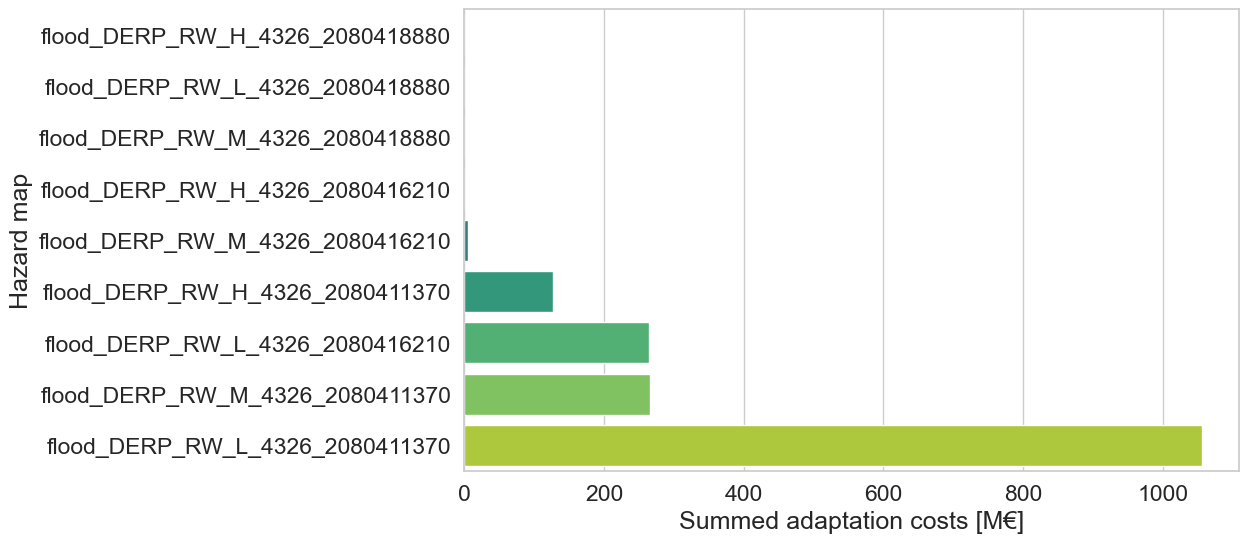

In [ ]:
#!pip install seaborn
#PLOT INDIRECT DAMAGES AND DIRECT DAMGES FOR EACH HAZARD MAP SORTED BY SUMMED ADAPTATION COSTS
import matplotlib.pyplot as plt
import seaborn as sns
total_damages_adapted_df_mill=total_damages_adapted_df_mill.sort_values(by='summed_adaptation_costs')
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.barplot(x='summed_adaptation_costs', y='hazard_map', data=total_damages_adapted_df_mill, palette='viridis', ax=ax)
ax.set_xlabel('Summed adaptation costs [M€]')
ax.set_ylabel('Hazard map')
plt.show()

C:\Users\peregrin\AppData\Local\Temp\ipykernel_10968\1228888211.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='indirect damage baseline [M€]', y='hazard_map', data=total_damages_adapted_df_mill, palette='viridis', ax=ax)


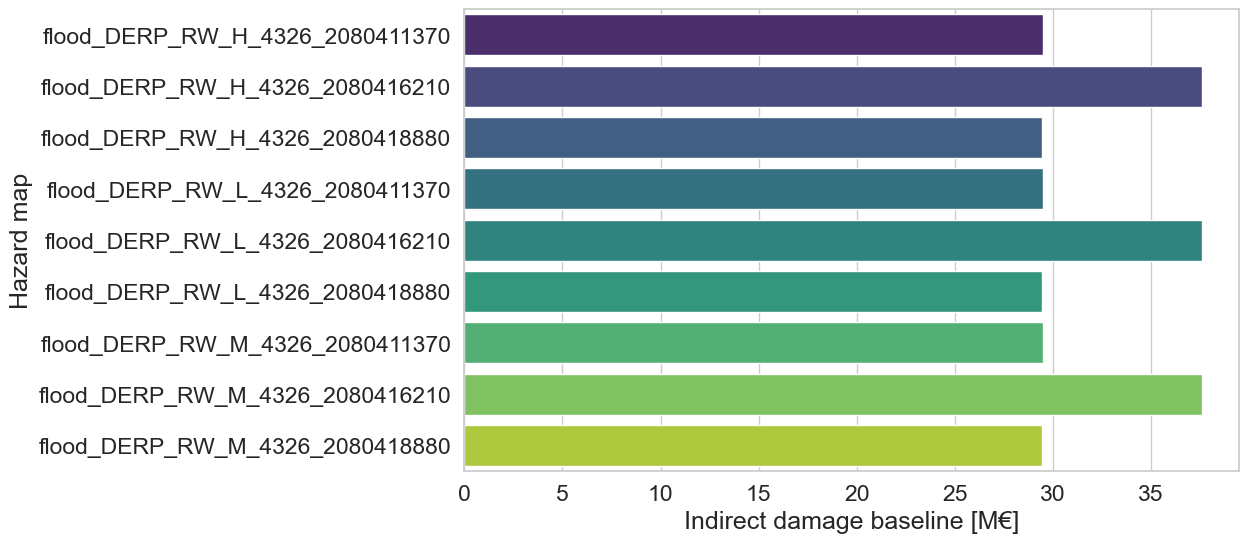

In [ ]:
#!pip install seaborn
#PLOT INDIRECT DAMAGES AND DIRECT DAMGES FOR EACH HAZARD MAP SORTED BY SUMMED ADAPTATION COSTS
# total_damages_adapted_df_mill['summed_dd_bl [M€]']=total_damages_adapted_df_mill['summed_dd_bl'].apply(lambda x: (x[0]/1e6, x[1]/1e6))
# total_damages_adapted_df_mill['summed_dd_ad [M€]']=total_damages_adapted_df_mill['summed_dd_ad'].apply(lambda x: (x[0]/1e6, x[1]/1e6))
# total_damages_adapted_df_mill['indirect damage baseline [M€]']=total_damages_adapted_df_mill['indirect damage baseline [€]']/1e6
# total_damages_adapted_df_mill['indirect damage adapted [M€]']=total_damages_adapted_df_mill['indirect damage adapted [€]']/1e6
# import matplotlib.pyplot as plt
# import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.barplot(x='indirect damage baseline [M€]', y='hazard_map', data=total_damages_adapted_df_mill, palette='viridis', ax=ax)
ax.set_xlabel('Indirect damage baseline [M€]')
ax.set_ylabel('Hazard map')
plt.show()




C:\Users\peregrin\AppData\Local\Temp\ipykernel_10968\3383329771.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='indirect damage adapted [M€]', y='hazard_map', data=total_damages_adapted_df_mill, palette='viridis', ax=ax)


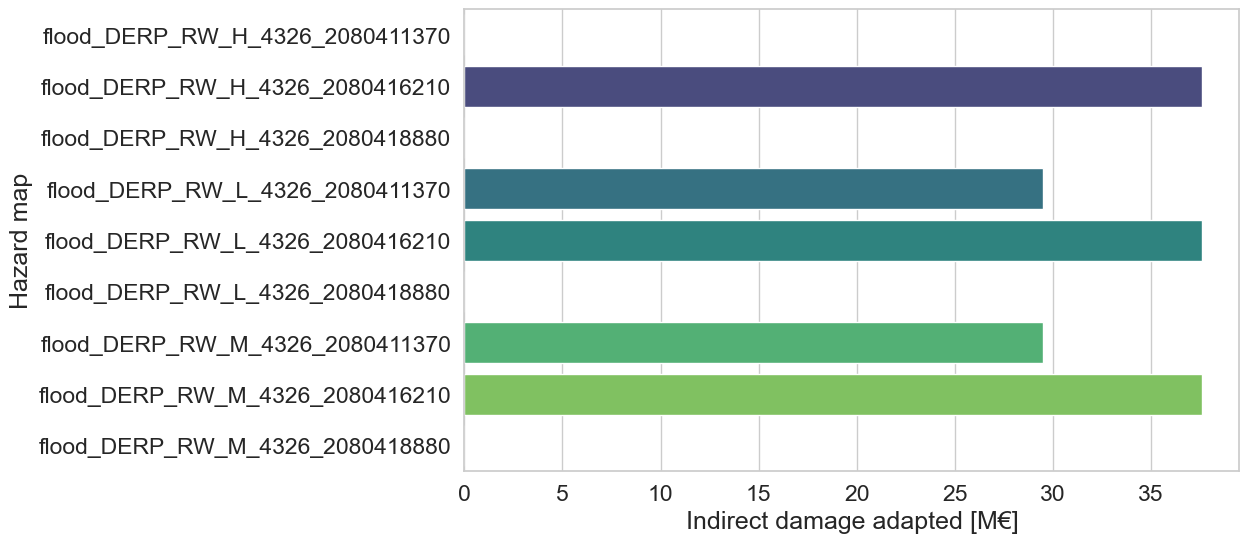

In [ ]:
# indirect damages adapted vs baseline
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.barplot(x='indirect damage adapted [M€]', y='hazard_map', data=total_damages_adapted_df_mill, palette='viridis', ax=ax)
ax.set_xlabel('Indirect damage adapted [M€]')
ax.set_ylabel('Hazard map')
plt.show()


C:\Users\peregrin\AppData\Local\Temp\ipykernel_10968\51968249.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='summed_adaptation_costs', y='hazard_map', data=total_damages_adapted_df_mill, palette='viridis', ax=ax)


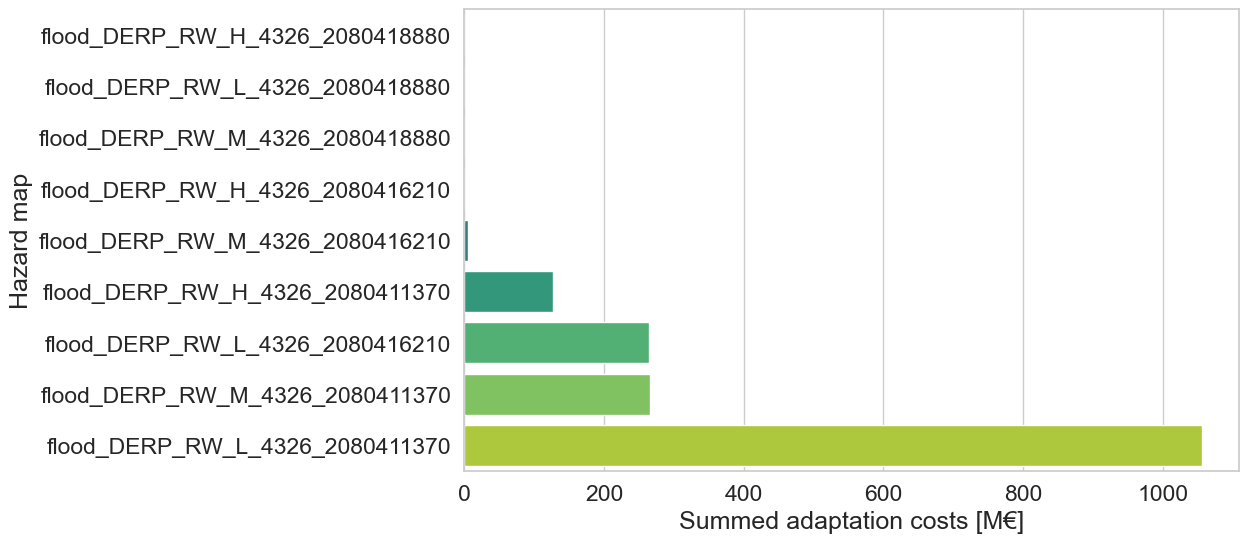

In [ ]:
#!pip install seaborn
#adaptation cost for each basin/hazard map
import matplotlib.pyplot as plt
import seaborn as sns
total_damages_adapted_df_mill=total_damages_adapted_df_mill.sort_values(by='summed_adaptation_costs')
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.barplot(x='summed_adaptation_costs', y='hazard_map', data=total_damages_adapted_df_mill, palette='viridis', ax=ax)
ax.set_xlabel('Summed adaptation costs [M€]')
ax.set_ylabel('Hazard map')
plt.show()

In [ ]:
import os


files = [file for file in os.listdir('C:/Data/interim/collected_flood_runs') if file.endswith('.pkl') and file.startswith('overlay')]
basins_list=list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))
basin_dict = {}
for basin in basins_list:
    basin_dict[basin] = {}
    for key in event_impacts.keys():
        if not str(basin) in key:
            continue
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = event_impacts[key]


for rp in return_period_dict.keys():
    # add rp as a key to all nested dictionaries with 0 as a value if the rp is not already a key
    for basin in basin_dict.keys():
        if rp not in basin_dict[basin].keys():
            basin_dict[basin][rp] = 0

basin_dict

aggregated_df_by_basin = {}
ead_by_ts_by_basin = {}

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue

    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total indirect damage'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_periods[index] for index in aggregated_df_by_basin[basin].index]
    probabilities = [[1 / rp for rp in ts] for ts in aggregated_df_by_basin[basin]['Return Period']]
    aggregated_df_by_basin[basin]['Probability'] = probabilities
    dmgs = []

    for ts in range(len(probabilities[0])):    
        dmgs_m = []

        for rp in range(len(probabilities)-1):
            d_rp= probabilities[rp][ts] - probabilities[rp + 1][ts]
            trap_damage_m = 0.5 * (aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp] + aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp + 1])
            dmgs_m.append(d_rp * trap_damage_m)
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities[-1][ts]
        damage_m0 = max(aggregated_df_by_basin[basin]['Total indirect damage'])
        dmgs_m.append(d0_rp * damage_m0)

        d_end_rp = (1/4)-probabilities[0][ts]
        damage_m_end = 0.5 * min(aggregated_df_by_basin[basin]['Total indirect damage'])

        dmgs_m.append(d_end_rp * damage_m_end)

        dmgs.append((sum(dmgs_m)))
    
    ead_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total indirect damage'])


IndexError: list index out of range

In [ ]:

print(direct_damages_adapted['flood_DERP_RW_H_4326_2080411370'][2])

# Ensure each entry in event_impacts contains both 'direct_damages' and 'indirect_damages'
# Adjust the dictionary if necessary
for key, value in event_impacts.items():
    if isinstance(value, dict):
        if 'direct_damages' not in value:
            value['direct_damages'] = 0  # or some default value
        if 'indirect_damages' not in value:
            value['indirect_damages'] = 0  # or some default value
    else:
        event_impacts[key] = {'direct_damages': direct_damages_adapted[key][0], 'indirect_damages': value}  # or some default value

# Create the DataFrame
baseline_impacts_by_hazard_map = pd.DataFrame.from_dict(event_impacts, orient='index', columns=['direct_damages', 'indirect_damages'])
baseline_impacts_by_hazard_map

{12: 39609.39689162098, 273: 830788.3098971696, 274: 1790189.151059401, 276: 293408.54381416214, 315: 60393241.31818281, 1008: 3286301.9719597776, 1011: 23357867.10514123, 1022: 2064287.0613990445, 1026: 293533.56254533475, 1031: 9218998.471346458, 1033: 1657081.6446989737, 1689: 4001966.9572467646, 2123: 567846.3061993018, 2126: 881928.699742678, 2127: 18465673.991132513, 2252: 29319.277056149996, 2648: 397753.2705784122}


,direct_damages,indirect_damages
flood_DERP_RW_H_4326_2080411370,"{12: (0.0, 6804.70524910867), 273: (35681.3661...",2.948015e+07
flood_DERP_RW_H_4326_2080416210,"{563: (3688.5159146512146, 13892.402545527659)}",3.761546e+07
flood_DERP_RW_H_4326_2080418880,{},2.945306e+07
flood_DERP_RW_L_4326_2080411370,"{12: (543666.1778714762, 2458653.921374703), 2...",2.948015e+07
flood_DERP_RW_L_4326_2080416210,"{563: (3110368.7603105297, 14508995.96075977),...",3.761546e+07
flood_DERP_RW_L_4326_2080418880,{},2.945306e+07
flood_DERP_RW_M_4326_2080411370,"{12: (35483.58764218136, 77196.03965774908), 2...",2.948015e+07
flood_DERP_RW_M_4326_2080416210,"{563: (103151.41725718141, 267849.5210491015),...",3.761546e+07
flood_DERP_RW_M_4326_2080418880,{},2.945306e+07


In [ ]:
# open pickled hazard-asset overlay and hazard intensity data
with open(interim_data_path / f'overlay_assets_flood_DERP_RW_{rp}_4326_{bas}.pkl', 'rb') as f:
    overlay_assets = pickle.load(f)
with open(interim_data_path / f'hazard_numpified_flood_DERP_RW_{rp}_4326_{bas}.pkl', 'rb') as f:
    hazard_numpified_list = pickle.load(f)

# optionally to calculate the maximum intensity for each hazard point, this can be used, else a float can be used
max_intensity = []
for asset_id in adapted_assets.index:
    max_intensity.append(retrieve_max_intensity_by_asset(asset_id, overlay_assets, hazard_numpified_list))


In [ ]:
# add new columns fragility_mod and haz_mod
adapted_assets['fragility_mod'] = 1 #[0.3, 0.5, 0.8] #fraction [example considering no reduction] (1 = no reduction, 0 = invulnerable asset) DUMMY DATA FOR TESTING
# adapted_assets['haz_mod'] = [np.max(x) for x in max_intensity] #meters [example adding wall of maximum flooding depth + 1 meter] (0 = no reduction in hazard intensity, 0.5 = 0.5 meter reduction in hazard intensity) DUMMY DATA FOR TESTING consider raising railway 0.5 meters
adapted_assets['haz_mod'] = [np.max(x) if len(x) > 0 else 0 for x in max_intensity]

# TODO: automate infrastructure curve deduction from dictionary keys, now running with curve F8.1
hazard_intensity = infra_curves['F8.1'].index.values
fragility_values = (np.nan_to_num(infra_curves['F8.1'].values,nan=(np.nanmax(infra_curves['F8.1'].values)))).flatten()
maxdams_filt=max_damage_tables[max_damage_tables['ID number']=='F8.1']['Amount']

adaptation_run = run_damage_reduction_by_asset(geom_dict, overlay_assets, hazard_numpified_list, adapted_assets, hazard_intensity, fragility_values, maxdams_filt, reporting=False)

#TODO Check with economist: ammortization of adaptation cost over years of adaptation scenario
    #NEXT: adaptation_run returns (collect_inb_bl, collect_inb_adapt, adaptation_cost). These can be used to calculate the EAD for the adapted scenario (and damage reduction), and compare with the adaptation cost, which must be ammortized over the years of the adaptation scenario.


c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


2024-07-31 19:03:58 - Calculating adapted damages for assets...


 86%|████████▌ | 37/43 [00:37<00:06,  1.02s/it]


KeyboardInterrupt: 

In [ ]:
# For a given hazard map overlay, find all the assets that are fully protected
fully_protected_assets=[asset_id for asset_id, damages in adaptation_run[1].items() if damages[0]==0 and damages[1]==0]

# For a given hazard map overlay, find all assets that are not exposed to flooding
unexposed_assets=[asset_id for asset_id in assets.index if asset_id not in overlay_assets.asset.values]
unexposed_osm_ids=assets.loc[assets.index.isin(unexposed_assets)]['osm_id'].values

# find the disrupted edges and paths under adapted conditions
disrupted_edges_by_basin_adapted = {}
disrupted_shortest_paths_adapted = {}
event_impacts_adapted = {}

for hazard_map in disrupted_edges_by_basin.keys():
    print(f'\n-- CALCULATIONS FOR {hazard_map} --')
    # find edges that will no longer be disrupted
    disrupted_edges = disrupted_edges_by_basin[hazard_map]
    print('disrupted_edges baseline: ', disrupted_edges)
    disrupted_edges_by_basin_adapted[hazard_map] = recalculate_disrupted_edges(G, assets, disrupted_edges, fully_protected_assets, unexposed_osm_ids)
    print('disrupted_edges_adapted: ', disrupted_edges_by_basin_adapted[hazard_map])

    disrupted_shortest_paths_adapted[hazard_map]=calculate_new_paths(G_v0, shortest_paths, disrupted_edges_by_basin_adapted[hazard_map])

    if disrupted_shortest_paths_adapted[hazard_map] == {}: # No disrupted paths, no economic impact
        print(f'No shortest paths disrupted for {hazard_map}. No economic impact.')
        event_impacts_adapted[hazard_map]=0
        continue

    impact=calculate_economic_impact_shortest_paths(G_v, shortest_paths, disrupted_shortest_paths_adapted[hazard_map], average_train_load_tons, average_train_cost_per_ton_km, average_road_cost_per_ton_km)
    event_impacts_adapted[hazard_map]=impact
    print(hazard_map, impact)
    




-- CALCULATIONS FOR flood_DERP_RW_H_4326_2080411370 --
disrupted_edges baseline:  [(397, 405), (398, 2349), (405, 397), (460, 2452), (461, 463), (463, 461), (1437, 2650), (1445, 1449), (1449, 1445), (1454, 2452), (1457, 1468), (1466, 1468), (1468, 1457), (1468, 1466), (1479, 1480), (1480, 1479), (2349, 398), (2452, 460), (2452, 1454), (2650, 1437)]
disrupted_edges_adapted:  []
No shortest paths disrupted for flood_DERP_RW_H_4326_2080411370. No economic impact.

-- CALCULATIONS FOR flood_DERP_RW_H_4326_2080416210 --
disrupted_edges baseline:  [(166, 2916), (203, 1668), (461, 463), (462, 532), (463, 461), (532, 462), (598, 2727), (717, 1737), (1392, 1940), (1394, 2728), (1398, 1937), (1433, 1438), (1437, 2650), (1438, 1433), (1654, 1669), (1668, 203), (1669, 1654), (1733, 1738), (1734, 1736), (1735, 1738), (1736, 1734), (1736, 1737), (1737, 1736), (1737, 717), (1738, 1735), (1738, 1733), (1937, 1398), (1940, 1392), (2650, 1437), (2727, 598), (2728, 1394), (2871, 2913), (2913, 2916), (29

In [ ]:
for hazard_map, impact in event_impacts.items():
    if hazard_map in event_impacts_adapted.keys():
        print(f'\nEconomic impact (adapted) for {hazard_map}: {event_impacts_adapted[hazard_map]:.2f} EUR')
        print(f'Economic impact (baseline) for {hazard_map}: {impact:.2f} EUR')
        change=(1-(event_impacts_adapted[hazard_map]/impact))*100
        print(f'Reduction: ', change, '%')


Economic impact (adapted) for flood_DERP_RW_H_4326_2080411370: 0.00 EUR
Economic impact (baseline) for flood_DERP_RW_H_4326_2080411370: 29480151.25 EUR
Reduction:  100.0 %

Economic impact (adapted) for flood_DERP_RW_H_4326_2080416210: 0.00 EUR
Economic impact (baseline) for flood_DERP_RW_H_4326_2080416210: 37615464.08 EUR
Reduction:  100.0 %

Economic impact (adapted) for flood_DERP_RW_H_4326_2080418880: 0.00 EUR
Economic impact (baseline) for flood_DERP_RW_H_4326_2080418880: 29453063.97 EUR
Reduction:  100.0 %

Economic impact (adapted) for flood_DERP_RW_L_4326_2080411370: 29480151.25 EUR
Economic impact (baseline) for flood_DERP_RW_L_4326_2080411370: 29480151.25 EUR
Reduction:  0.0 %

Economic impact (adapted) for flood_DERP_RW_L_4326_2080416210: 0.00 EUR
Economic impact (baseline) for flood_DERP_RW_L_4326_2080416210: 37615464.08 EUR
Reduction:  100.0 %

Economic impact (adapted) for flood_DERP_RW_L_4326_2080418880: 0.00 EUR
Economic impact (baseline) for flood_DERP_RW_L_4326_20804

In [ ]:
# EXPAND FOR VISUALISATION SCRIPT
# Create visualisation for the basin and the discharge points
from lonboard import Map, PolygonLayer, PathLayer, BaseLayer
import ast
# MIRACA color scheme
color_string = config.get('DEFAULT', 'miraca_colors')
miraca_colors = ast.literal_eval(color_string)

basin_id = 2080411370

    
# Set path for basin to add to visualization
basin_path = rf'C:\Data\Floods\basins\hybas_eu_{int(basin_id)}.shp'

# Generate the basin layer
basin = gpd.read_file(basin_path)
layer_basin = PolygonLayer.from_geopandas(basin,
    get_fill_color=miraca_colors['grey_200'],
    get_line_color=miraca_colors['primary blue'], get_line_width=70,
    auto_highlight=False,
    filled=True, opacity=0.2)

# Set path for the protected area to add to visualization
# adapt_path = rf'C:\Data\interim\adaptations\test_haz_level_adapt.geojson'
adapt_area = gpd.read_file(adapt_path)
layer_adapted_area = PolygonLayer.from_geopandas(adapt_area,
    get_fill_color=miraca_colors['green_success'],
    get_line_color=miraca_colors['green_400'], get_line_width=30,
    auto_highlight=False,
    filled=True, 
    opacity=0.2)

# Create layer for assets for visualization
layer_assets = PathLayer.from_geopandas(assets.drop(columns=['buffered']), get_width=2, get_color=miraca_colors['black'], auto_highlight=True, )
affected_assets = [asset_id for asset_id in list(set(overlay_assets.asset.values))]
layer_affected_assets = PathLayer.from_geopandas(assets.iloc[affected_assets].drop(columns=['buffered']), get_width=3, get_color=miraca_colors['red_danger'], auto_highlight=True)
layer_protected_assets = PathLayer.from_geopandas(adapted_assets.drop(columns=['buffered']), get_width=4, get_color=miraca_colors['green_success'], auto_highlight=True)
layers_assets = [layer_assets, layer_affected_assets, layer_protected_assets]
# Flood return period: H for frequent(RP10-20), M for 100 year return period (RP100) and L for extreme (RP2000)
return_period_str='M'
# Generate flood layers and protection layers for visualization
flood_plot_path=rf'Floods\Germany\basin_intersections\DERP_RW_{return_period_str}_4326_hybas_intersections\flood_DERP_RW_{return_period_str}_4326_{basin_id}.geojson'
flood_m = data_path / flood_plot_path
flood_gdf=gpd.read_file(flood_m)
layers_flood=[]
f_area_colors = {1:'blue', 3:'green'}
for f_area in flood_gdf.flood_area.unique():
    for f_depth in flood_gdf.depth_class.unique():
        subset_gdf = flood_gdf[(flood_gdf.depth_class==f_depth) & (flood_gdf.flood_area==f_area)]
        if not subset_gdf.empty:
            color_key=f'{f_area_colors[f_area]}_{f_depth}00'
            layers_flood.append(PolygonLayer.from_geopandas(subset_gdf, 
                                                            get_fill_color=miraca_colors[color_key], 
                                                            opacity=0.5, 
                                                            stroked=False))


layers=[]
if layer_basin is not None:
    layers.append(layer_basin)
else:
    print('No basin layer')

if layer_adapted_area is not None:
    layers.append(layer_adapted_area)
else:
    print('No protected area layer')

if layers_flood is not None:
    layers.extend(layers_flood)
else:
    print('No flood layers')

if layers_assets is not None:
    layers.extend(layers_assets)
else:
    print('No asset layer')
Voyager = 'https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json'


# m=Map(layer_affected_assets, show_tooltip=True, basemap_style=Voyager)
m = Map(layers, show_tooltip=True, basemap_style=Voyager)



c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\lonboard\_geoarrow\ops\reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")
c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\lonboard\_geoarrow\ops\reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")
c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\lonboard\_geoarrow\ops\reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [ ]:

m



Map(basemap_style='https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json', layers=[PolygonLayer(filled=…